In [71]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Read training/evaluation data

**Argument(s):** 
1) filename: name of a .txt file with each line containing training/evaluation features(x) and label(y) in the following format:
((x1, x2, .....xn), y) <br>
2) dtype_x : datatype of features <br>
3) dtype_y: datatype of label <br>

**Return(s):** 'X, Y' where X is a numpy array of feature vectors and Y is the target label vector.
Note: <br>
Each column in the array(s) epresents a single datapoint. <br>
Also removes the fourth attribute 'hue'.

In [72]:
def get_X_Y_arrays(filename, dtype_x, dtype_y):
    try:
        f = open(filename, 'r')
    except OSError:
        print(f'{filename} could not be opened.\n')
        sys.exit()

    # initialize list to store feature and labels for training data
    features = []
    labels = []

    with f:
        line = f.readline()
        while line != '':
            # strip newline and outer parenthesis
            line = line.strip('\n')
            line = line.strip('( )')

            # extrace label and append to labels list
            single_label = line.split('), ')[-1]
            labels.append(single_label)

            # extrace features and append to features list
            feat = line.split('), ')[0].split(', ')
            features.append(feat)

            # read next line
            line = f.readline()

        # create dataframe of features and append labels
        X = np.array(features, dtype=dtype_x, ndmin=2)

        # convert labels list to array
        Y = np.array(labels, dtype=dtype_y)

        return X, Y
    
    

## Helper Functions

In [73]:
# given a numpy array of text labels, converts labels to binary
# with 'label' = 1 and everything as 0
def get_encoded_binary_labels(Y, label):
    # get the number of samples
    n_samples = Y.shape[0]

    encoded_arr = np.zeros(n_samples)

    for i in range(n_samples):
        if Y[i] == label:
            encoded_arr[i] = 1
        else:
            encoded_arr[i] = -1
    return encoded_arr


# splits data into training and test set
# first 6 datapoints become the test datapoints
def split_data(X, Y):

    X_test = X[0:6, :]
    Y_test = Y[0:6]

    X_train = np.delete(X, np.s_[0:6], axis = 0)
    Y_train = np.delete(Y, np.s_[0:6])

    return X_train, Y_train, X_test, Y_test

## 2 a) Linear Classifier

### Provide filename

In [74]:
fname = '2_data.txt'

In [75]:
# read data 
X, Y = get_X_Y_arrays(fname, float, str)

#### Plot class distribution of training data provided in assignment

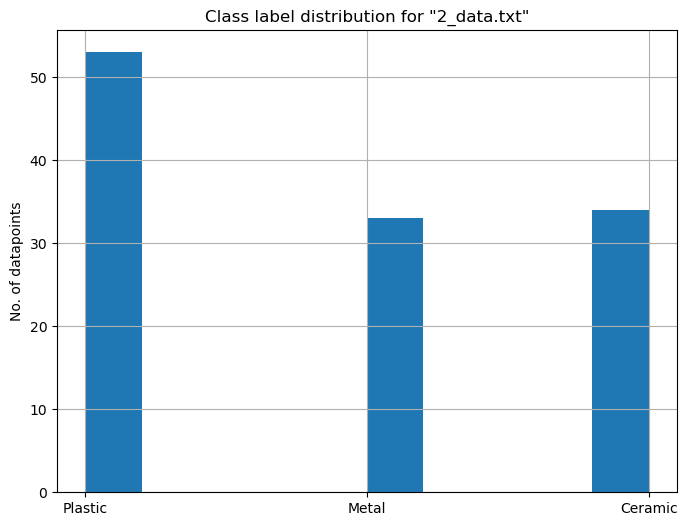

In [76]:
plt.figure(figsize = (8, 6))
plt.title(f'Class label distribution for "{fname}"')
plt.ylabel('No. of datapoints')
plt.hist(Y)
plt.grid()

#### Plot Dataset

In [77]:
# choose a class to be the positive class
pos_c_label = 'Plastic'

# get encoded values for y
Y = get_encoded_binary_labels(Y, pos_c_label)

# split data into train and test set
X_train, Y_train, X_test, Y_test = split_data(X, Y)

In [78]:
# create training and test dataframes
df_train = pd.DataFrame(np.concatenate((X_train, Y_train.reshape(X_train.shape[0], 1)), axis = 1),
                  columns = ['height', 'diameter', 'weight', 'hue', pos_c_label])

df_test = pd.DataFrame(np.concatenate((X_test, Y_test.reshape(X_test.shape[0], 1)), axis = 1),
                  columns = ['height', 'diameter', 'weight', 'hue', pos_c_label])

### Functions for plotting

In [79]:
# creates a scatter plot
def plot_scatter(df_train, df_test, xlab, ylab, title):
    
    plt.figure(figsize = (8, 6))
    # plot prediction on training data
    plt.scatter(x = df_train[df_train[pos_c_label] == 1][xlab],
                y = df_train[df_train[pos_c_label] == 1][ylab], color = 'deepskyblue')
    plt.scatter(x = df_train[df_train[pos_c_label] == -1][xlab],
                y = df_train[df_train[pos_c_label] == -1][ylab], color = 'orange')
    
    # plot prediction on test data
    plt.scatter(x = df_test[df_test[pos_c_label] == 1][xlab],
                y = df_test[df_test[pos_c_label] == 1][ylab], color = 'blue')
    plt.scatter(x = df_test[df_test[pos_c_label] == -1][xlab],
                y = df_test[df_test[pos_c_label] == -1][ylab], color = 'red')
    plt.grid()
    plt.legend([pos_c_label, 'Other', f'Test datapoints({pos_c_label})', 'Test_datapoints(Other)'])
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    
    

# creates a 2D plot of training, test datapoints, support vectors and the descision boundary
def plot_spvec_desc_boundary(df, dfsp, xlab, ylab, title, w1 = None, w2 = None, bias = None):
    
    # plot training data and support vectors
    plt.figure(figsize = (8, 6))
    
    # plot training data and support vectors
    plt.scatter(x = df[df[pos_c_label] == 1][xlab], y = df[df[pos_c_label] == 1][ylab], color = 'deepskyblue')
    plt.scatter(x = df[df[pos_c_label] == -1][xlab], y = df[df[pos_c_label] == -1][ylab], color = 'orange')
    plt.scatter(x = dfsp[xlab], y =dfsp[ylab], color = 'gray')
    plt.grid()
    
    # get datapoints to plot descision boundary
    x_dps = np.linspace(min(df[xlab])-0.02, max(df[xlab])+0.02)
    y_dps = -((w1/w2)*x_dps) - (bias/w2)
    
    # plot descision boundary
    plt.plot(x_dps, y_dps, color = 'red')
    
    plt.xlim(min(df[xlab])-0.02, max(df[xlab])+0.02)
    plt.ylim(min(y_dps)-0.02, max(df[ylab])+0.02)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend([pos_c_label, 'Other', 'support vectors', 'descision boundary'],
               loc = 'lower right')
    

    
# plots training vs test error
def plot_training_vs_test_acc(training_err, test_err, title_str, xlab, ylab):
    
    # plot training VS test error for given function depth(d)
    fig = plt.figure(figsize = (8, 6))
    plt.plot(training_err, color = 'blue')
    plt.plot(test_err, color = 'green')
    
    # add title, labels and legend
    plt.title(title_str, fontdict = {'fontsize': 15})
    plt.legend(['Training Accuracy', 'Test Accuracy'])
    plt.xlabel(xlab, fontdict = {'fontsize': 12})
    plt.ylabel(ylab, fontdict = {'fontsize': 12})
    plt.grid()
    

### Plot Datapoints for visualization

#### height vs diameter

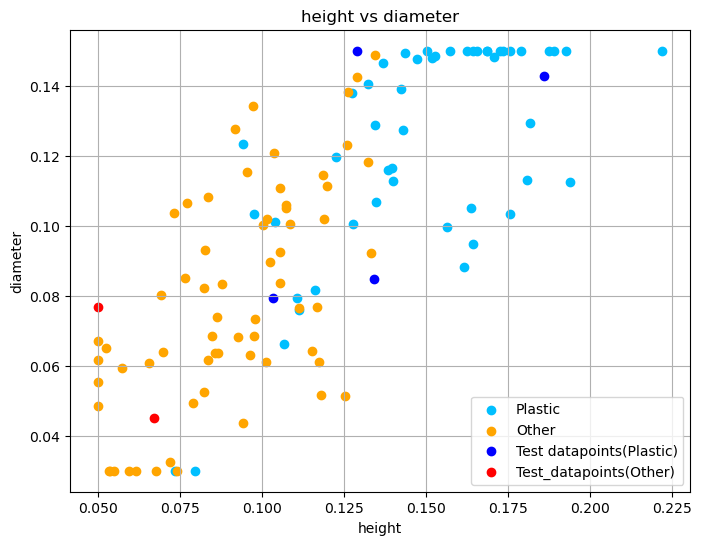

In [80]:
plot_scatter(df_train, df_test, 'height', 'diameter', 'height vs diameter')

#### height vs weight

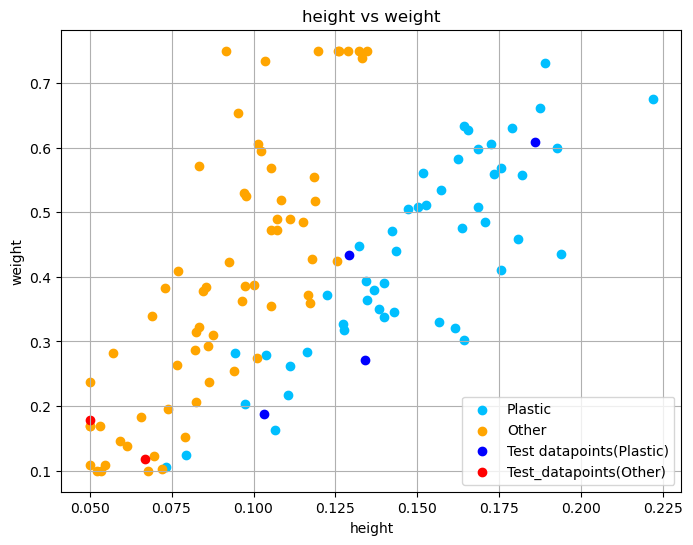

In [81]:
plot_scatter(df_train, df_test, 'height', 'weight', 'height vs weight')

#### diameter vs weight

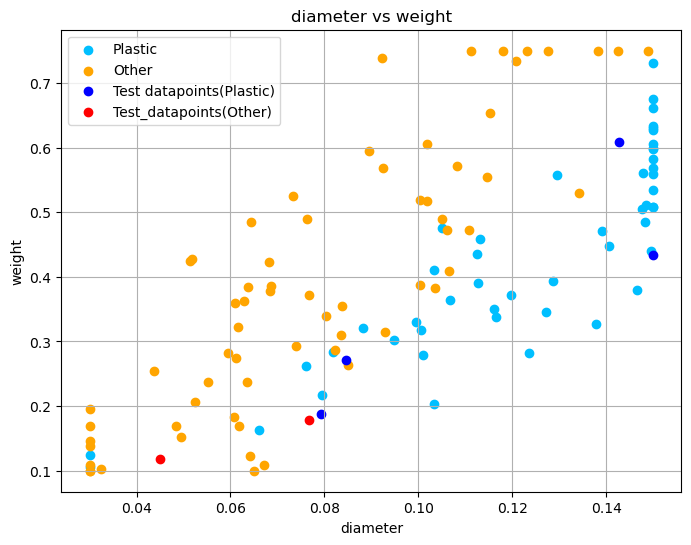

In [82]:
plot_scatter(df_train, df_test,'diameter', 'weight', 'diameter vs weight')

### Import SVM from scikit-learn

In [83]:
import sklearn
from sklearn.svm import SVC

In [84]:
# this fucntion creates an SVM model for various values of c 
# and returns training and test accuracy
def get_model_accuracy(model_type, c, X_train, Y_train, X_test, Y_test, gamma = None):
    
    if model_type == 'linear':
        svm_model = SVC(C = c, kernel = 'linear')
    else:
        if gamma == None: # use default value
            svm_model = SVC(C = c, kernel = 'rbf')
        else:
            svm_model = SVC(C = c, gamma = gamma, kernel = 'rbf')
        
    # train model
    svm_model.fit(X_train, Y_train)
    
    # get predictions and accuracy
    # training accuracy
    Y_pred_train = svm_model.predict(X_train)
    tr_acc = sklearn.metrics.accuracy_score(Y_train, Y_pred_train)

    # est accuracy
    Y_pred_test = svm_model.predict(X_test)
    tst_acc = sklearn.metrics.accuracy_score(Y_test, Y_pred_test)
    
    return svm_model, tr_acc, tst_acc

### Linear Model

In [85]:
# initialize Linear model
c = 100
svm_linear, tr_acc, tst_acc = get_model_accuracy('linear', c, X_train, Y_train, X_test, Y_test)

In [86]:
print(f'Training acuracy with a regularization value of {c} is {tr_acc:0.3f}.')
print(f'Test acuracy with a regularization value of {c} is {tst_acc:0.3f}.')

Training acuracy with a regularization value of 100 is 0.982.
Test acuracy with a regularization value of 100 is 1.000.


#### Get coefficients of the descision boundary

In [87]:
# get coefficients for all attributes except "hue"
h_coeff = svm_linear.coef_[0,0]
d_coeff = svm_linear.coef_[0,1]
w_coeff = svm_linear.coef_[0,2]
b = svm_linear.intercept_[0]

# print coefficients
print(f'weights: {svm_linear.coef_}')
print(f'bias: {svm_linear.intercept_}')

weights: [[35.2059888  22.85565264 -7.44291004 -0.03894953]]
bias: [-3.48892287]


#### Get support vectors

In [88]:
sp_vectors = svm_linear.support_vectors_
df_sp = pd.DataFrame(sp_vectors, columns = ['height', 'diameter', 'weight', 'hue'])
print("The Support vectors for the linear model are:\n")
df_sp

The Support vectors for the linear model are:



,height,diameter,weight,hue
0,0.076536,0.085016,0.263367,3.441823
1,0.078976,0.049397,0.151682,3.824761
2,0.105339,0.110754,0.472215,2.512735
3,0.105384,0.083726,0.355479,3.875198
4,0.052307,0.065041,0.100000,2.423934
5,0.118732,0.101942,0.517395,4.388636
6,0.116547,0.076688,0.372611,3.208547
7,0.100273,0.100246,0.387951,2.590156
8,0.082202,0.082293,0.286432,3.621779
9,0.107198,0.106059,0.472547,3.511542


### Linear model: Plot descision boundary and support vectors

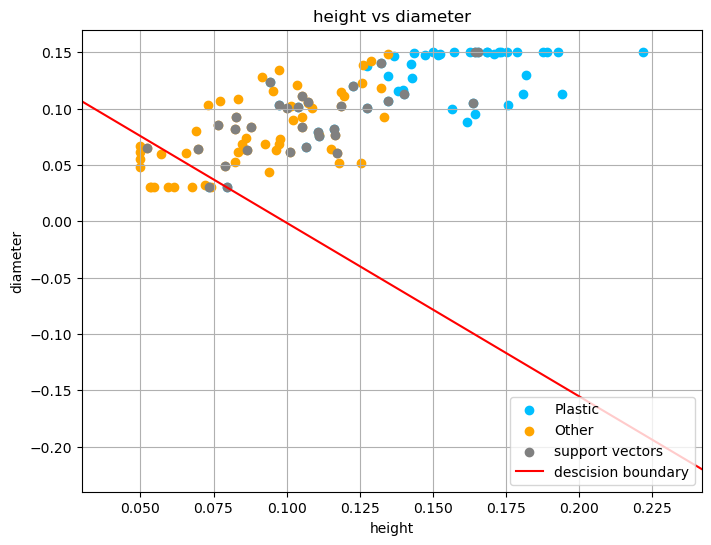

In [89]:
plot_spvec_desc_boundary(df_train, df_sp, 'height', 'diameter', 'height vs diameter', h_coeff, d_coeff, b)

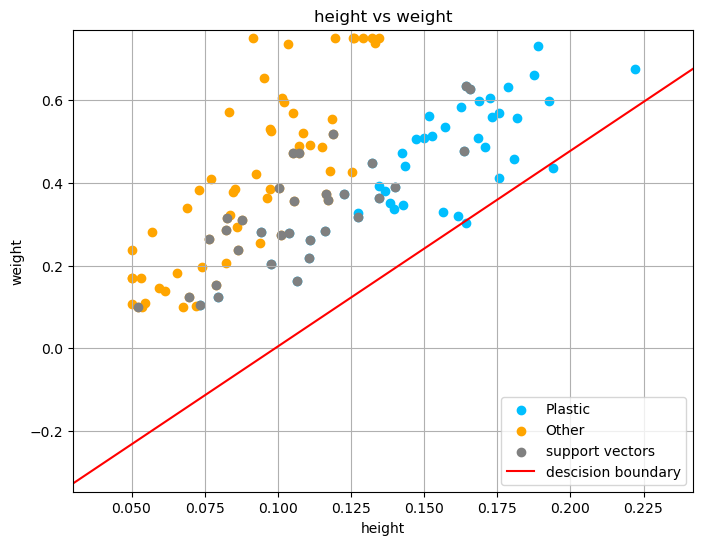

In [90]:
plot_spvec_desc_boundary(df_train, df_sp, 'height', 'weight', 'height vs weight', h_coeff, w_coeff, b)

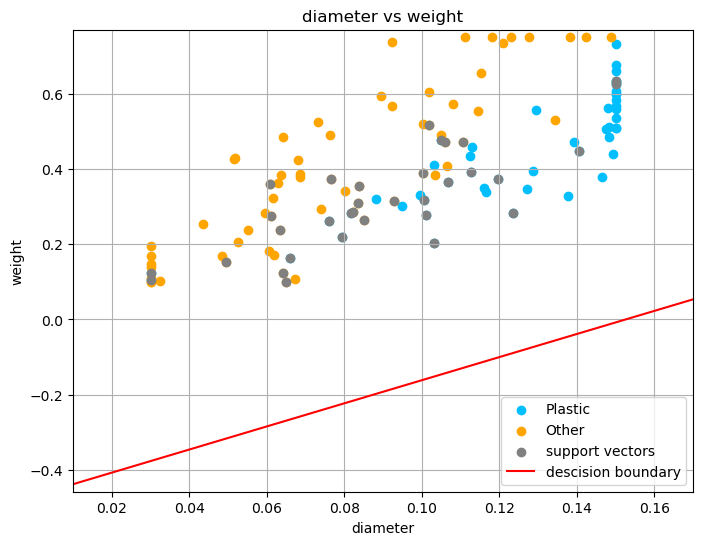

In [91]:
plot_spvec_desc_boundary(df_train, df_sp, 'diameter', 'weight', 'diameter vs weight', d_coeff, w_coeff, b)

#### Get training and test accuracy for various values of C

In [92]:
training_error = []
test_error = []
c_max = 200
for c in range(1, c_max):
    __, tr_err, tst_err = get_model_accuracy('linear', c, X_train, Y_train, X_test, Y_test)
    training_error.append(tr_err)
    test_error.append(tst_err)

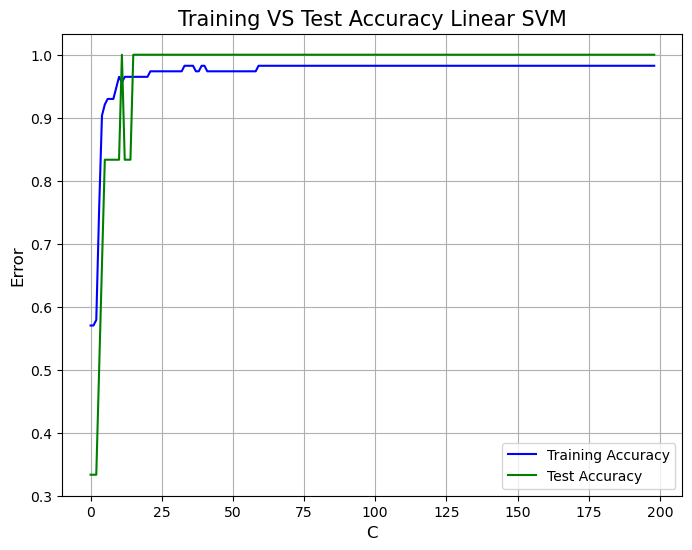

In [93]:
plot_training_vs_test_acc(training_error, test_error, 'Training VS Test Accuracy Linear SVM', 'C', 'Error')

In [94]:
# get maximum accuracy value
max_val = max(training_error)
C_val = training_error.index(max_val)
print(f'The maximum accuracy for training is {max(training_error):0.3f} for C = {C_val}.')

# get maximum accuracy value
max_val = max(test_error)
C_val = test_error.index(max_val)
print(f'The maximum accuracy for test is {max(test_error):0.3f} for C = {C_val}.')

The maximum accuracy for training is 0.982 for C = 33.
The maximum accuracy for test is 1.000 for C = 11.


### 2 a) Conclusion
In this case where 'Plastic' was chosen to be the positive class, it can be seen that the most of the data is linearly separable. Accuracy of both the training and the test datapoints increases with an increase in the regularization parameter 'C'. This makes sense for data that is linearly separable as higher values of 'C' corresponds to bigger penatly and smaller margins. However, the test accuracy being higher than the training accuracy indicates possibility of bias in the test data or could also be a result of the test data being too small.

## 2 b) Non-Linear Classifier

In [95]:
# initialize non-linear model and get accuracy
c = 1
gamma = 7
svm_nonlinear, tr_acc, tst_acc = get_model_accuracy('non linear', c, X_train, Y_train, X_test, Y_test, gamma)

In [96]:
print(f'Training acuracy with a regularization value of {c} is {tr_acc:0.3f}.')
print(f'Test acuracy with a regularization value of {c} is {tst_acc:0.3f}.')

Training acuracy with a regularization value of 1 is 0.772.
Test acuracy with a regularization value of 1 is 0.500.


#### Get training and test accuracy for various values of gamma (Uses default value of C)

In [97]:
training_error = []
test_error = []
c = 1
gamma_max = 150
for gamma in range(0, gamma_max):
    __, tr_err, tst_err = get_model_accuracy('non linear', c, X_train, Y_train, X_test, Y_test, gamma)
    training_error.append(tr_err)
    test_error.append(tst_err)

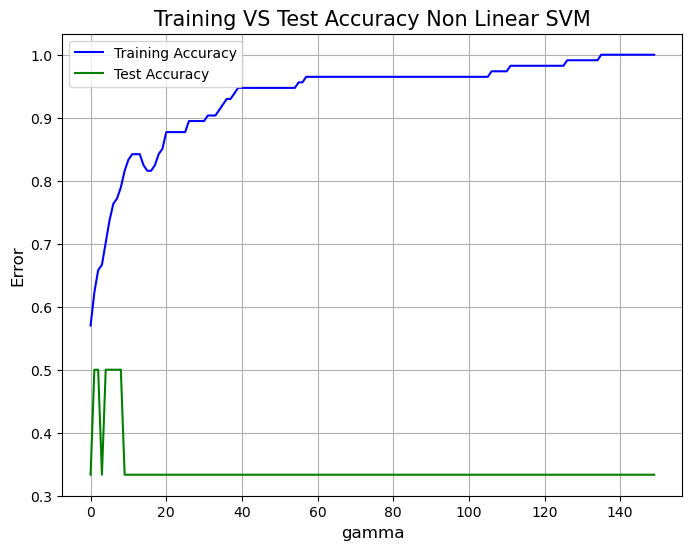

In [98]:
plot_training_vs_test_acc(training_error, test_error, 'Training VS Test Accuracy Non Linear SVM', 'gamma', 'Error')

In [99]:
# get maximum accuracy value
max_val = max(training_error)
gamma_val = training_error.index(max_val)
print(f'The maximum accuracy for training is {max(training_error):0.3f} for C = {c} and gamma = {gamma_val}.')

max_val = max(test_error)
gamma_val = test_error.index(max_val)
print(f'The maximum accuracy for test is {max(test_error):0.3f} for C = {c} and gamma = {gamma_val}.')

The maximum accuracy for training is 1.000 for C = 1 and gamma = 135.
The maximum accuracy for test is 0.500 for C = 1 and gamma = 1.


### Conclusion 2 b)-2

The figure above shows that although training accuracy steadily increases with an increase in the gamma value. Test accuracy gets worse. This indicates overfitting of the model on training data. In addition the fact that the non-linear model had a miximum accuracy of 0.5 for C = 1 and Gamma = 1 shows that the data may not be non-linear. <br>

As the linear model was able to get a better accuracy score (1.0) on the test data. This suggests that the data may have been linearly separable.

### Plotting Predictions

In [100]:
# creates a 2D plot of training, test datapoints, support vectors and the descision boundary
def plot_spvec_desc_boundary(df_train_pred, xlab, ylab, title, df_test_pred = None, df_sp_n = None):
    
    # plot training data and support vectors
    plt.figure(figsize = (8, 6))
    
    # plot prediction on training data
    plt.scatter(x = df_train_pred[df_train_pred[pos_c_label] == 1][xlab],
                y = df_train_pred[df_train_pred[pos_c_label] == 1][ylab], color = 'deepskyblue')
    plt.scatter(x = df_train_pred[df_train_pred[pos_c_label] == -1][xlab],
                y = df_train_pred[df_train_pred[pos_c_label] == -1][ylab], color = 'orange')
    
    if df_test_pred is not None:
        # plot prediction on test data
        plt.scatter(x = df_test_pred[df_test_pred[pos_c_label] == 1][xlab],
                    y = df_test_pred[df_test_pred[pos_c_label] == 1][ylab], color = 'blue')
        plt.scatter(x = df_test_pred[df_test_pred[pos_c_label] == -1][xlab],
                    y = df_test_pred[df_test_pred[pos_c_label] == -1][ylab], color = 'red')
        plt.legend([pos_c_label, 'Other', f'Test datapoints({pos_c_label})', 'Test datapoints(Other)'],
               loc = 'lower right')
        
    if df_sp_n is not None:
        # plot support vectors
        plt.scatter(x = df_sp_n[xlab], y =df_sp_n[ylab], c = 'gray')
        plt.legend([pos_c_label, 'Other', 'support vectors'],
               loc = 'lower right')
    
    
    # add labels and title
    plt.grid()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    

### Create final non-linear model with best test accuracy

In [101]:
c = 1
gamma = 7
svm_nonlinear, tr_acc, tst_acc = get_model_accuracy('non linear', c, X_train, Y_train, X_test, Y_test, gamma)

In [102]:
# get predictions for initial model
Y_train_pred = svm_nonlinear.predict(X_train)
Y_test_pred = svm_nonlinear.predict(X_test)

In [103]:
# get support vectors
sp_vectors_n = svm_nonlinear.support_vectors_
df_sp_n = pd.DataFrame(sp_vectors_n, columns = ['height', 'diameter', 'weight', 'hue'])
print('The Support Vectors for the non-linear model are:\n')
df_sp_n.tail(20)

The Support Vectors for the non-linear model are:



,height,diameter,weight,hue
82,0.110591,0.079459,0.217766,1.506114
83,0.132239,0.140489,0.448283,1.068177
84,0.164305,0.150000,0.633224,3.401069
85,0.073418,0.030000,0.105073,3.144398
86,0.178751,0.150000,0.630433,2.090222
87,0.106479,0.066073,0.162842,3.282152
88,0.170707,0.148268,0.485685,4.247617
89,0.142950,0.127221,0.346243,4.212555
90,0.111162,0.076056,0.262777,2.898434
91,0.116181,0.081749,0.284026,1.646664


In [104]:
# create training and test dataframes
df_train_pred = pd.DataFrame(np.concatenate((X_train, Y_train_pred.reshape(X_train.shape[0], 1)), axis = 1),
                  columns = ['height', 'diameter', 'weight', 'hue', pos_c_label])
df_test_pred = pd.DataFrame(np.concatenate((X_test, Y_test_pred.reshape(X_test.shape[0], 1)), axis = 1),
                  columns = ['height', 'diameter', 'weight', 'hue', pos_c_label])

### Non-linear model: Predictions

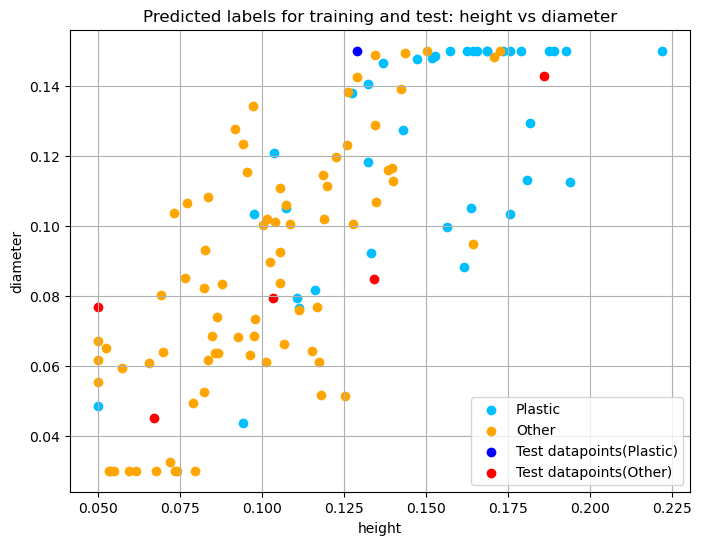

In [105]:
plot_spvec_desc_boundary(df_train_pred, 'height', 'diameter',
                         'Predicted labels for training and test: height vs diameter', df_test_pred = df_test_pred)

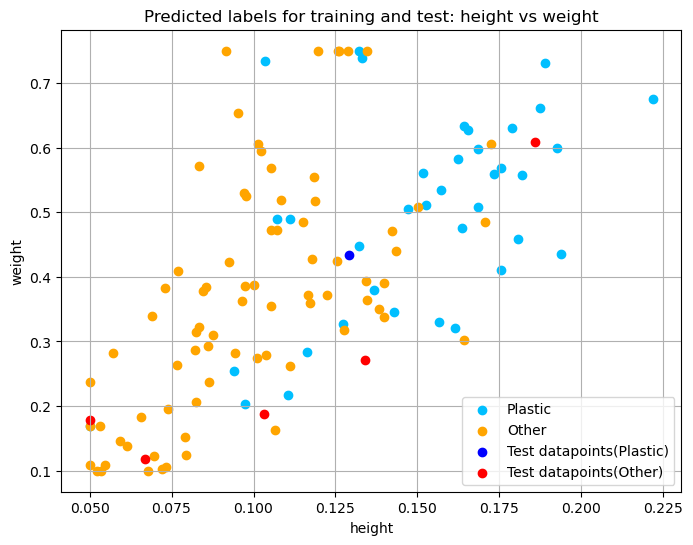

In [106]:
plot_spvec_desc_boundary(df_train_pred, 'height', 'weight',
                         'Predicted labels for training and test: height vs weight', df_test_pred = df_test_pred)

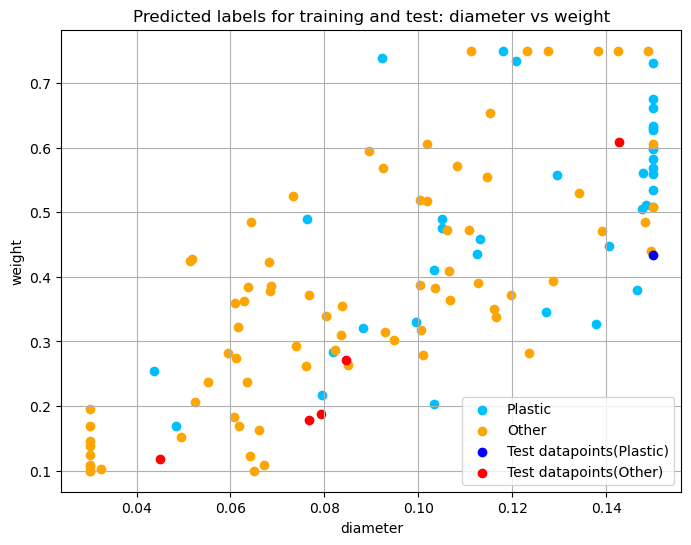

In [107]:
plot_spvec_desc_boundary(df_train_pred, 'diameter', 'weight',
                         'Predicted labels for training and test: diameter vs weight', df_test_pred = df_test_pred)

### Non-linear model: Plot Support Vectors

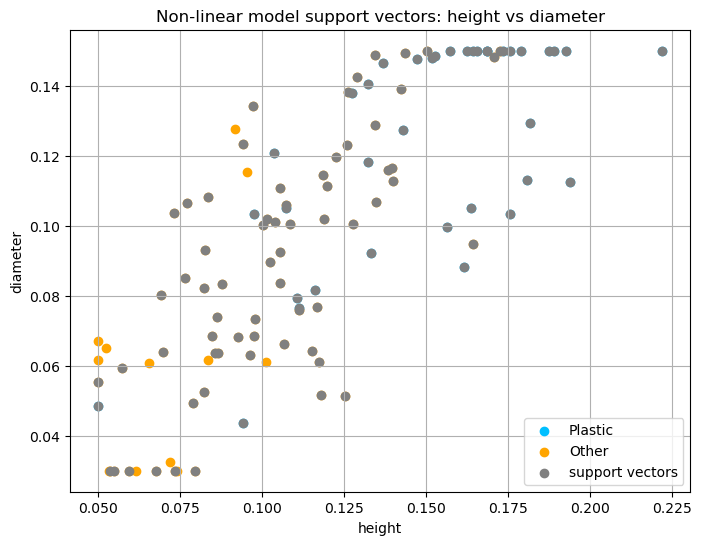

In [108]:
plot_spvec_desc_boundary(df_train_pred, 'height', 'diameter',
                         'Non-linear model support vectors: height vs diameter', df_sp_n = df_sp_n)

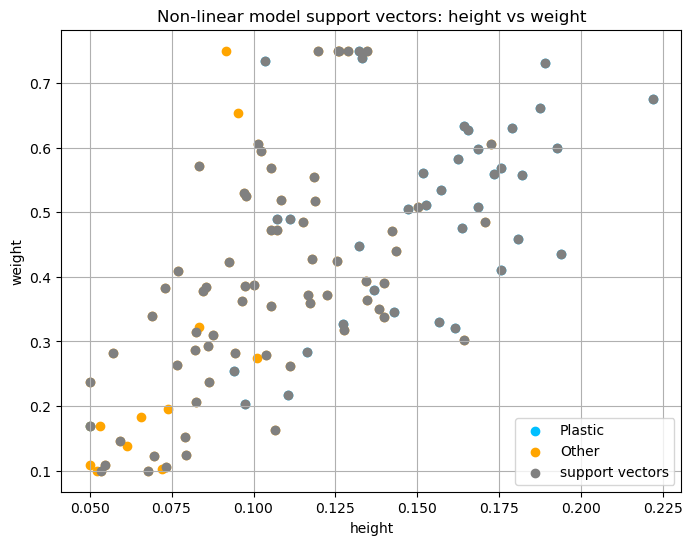

In [109]:
plot_spvec_desc_boundary(df_train_pred, 'height', 'weight',
                         'Non-linear model support vectors: height vs weight', df_sp_n = df_sp_n)

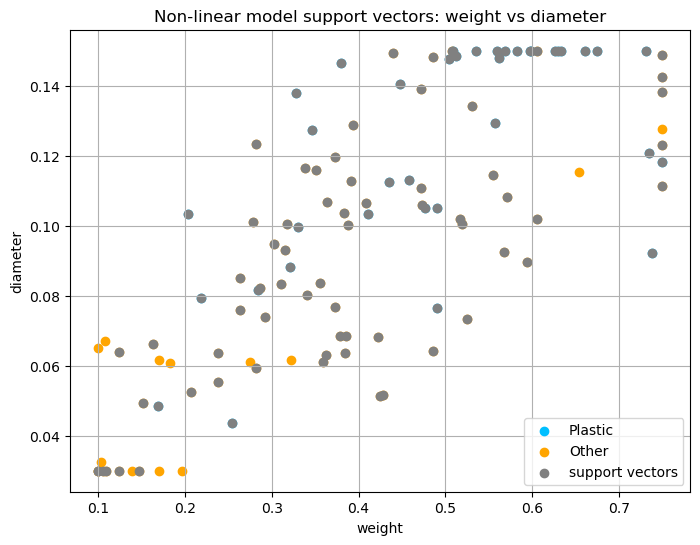

In [110]:
plot_spvec_desc_boundary(df_train_pred, 'weight', 'diameter',
                         'Non-linear model support vectors: weight vs diameter', df_sp_n = df_sp_n)